## ToDo List
- [x] Checar se formato de datas conferem.
- [x] Remover UGs sem liberação OC
- [x] Considerar coluna montagem. Onde estiver vazio, pegar valor de Torres para EOL, no skate.
- [ ] Separar um cojunto aleatório para teste
- [x] Calcular tempos de construção por marco: (IO_realizado - realizado), (CC_realizado - realizado) ...etc  (ordem:IO,CC,ME,OT)
- [x] Calcular atraso da operação comercial (realizado - outorgado)
- [x] Calcular média e dp do tempo de construção.
- [x] Calcular data dos marcos medios (outorgado - tempo_medio_de_construcao) por fonte.
- [x] Calcular atrasos com base nos marcos medios
- [x] Calcular media e dp dos atrasos. 
- [ ] Normalizar os atrasos calculados (atraso - atraso_medio)/dp
- [x] Construir matriz de correlação de Pearson
- [ ] Calcular os coeficientes para regressão linear
- [x] Para UHE pegar todas UGs, para as demais pegar a primeira UG apenas 
- [ ] Comparar pegando primeira UG e media por grupo

In [1]:
import pandas as pd
import numpy as np
import re
import pyodbc
from pprint import pprint
import matplotlib.pyplot as plt
from scipy import stats
from itertools import combinations

In [2]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)

#### Transforma coluna IdeUsinaOutorga das UHEs para que cada UG possua esse campo diferente. Por exemplo as UGs da usina 12 serão 12_0, 12_1...

In [3]:
bd_combined = pd.read_parquet("bd_combined.gzip")

In [4]:
bd_combined.index.name = "idx"
bd_combined.IdeUsinaOutorga = bd_combined.IdeUsinaOutorga.astype(str)
mask_UHE_duplicate = (bd_combined.SigTipoGeracao == "UHE") & (bd_combined.IdeUsinaOutorga.duplicated(keep=False))
#bd_combined.loc[mask_UHE_duplicate,"IdeUsinaOutorga"] = bd_combined.loc[mask_UHE_duplicate,"IdeUsinaOutorga"] +"_"+ bd_combined.loc[mask_UHE_duplicate].groupby("IdeUsinaOutorga").cumcount().astype(str)
bd_combined.sample(15)

,IdeUsinaOutorga,DatInicioOpTesteOutorgada,DatUGInicioOpComerOutorgado,DatLiberacaoSFGTeste,DatLiberOpComerRealizado,UFUsina,VlrPotenciaOutorgada,DatInicioObraOutorgado,DatInicioObraRealizado,DatConcretagemOutorgado,...,Torres_Real,DatEnchimentoOutorgado,DatEnchimentoRealizado,DatSisTransmissaoOutorgado,DatSisTransmissaoRealizado,SigTipoGeracao,Quant_UG,Pot_UG,origem,DatOutorgaUsina
idx,,,,,,,,,,,,,,,,,,,,,
5156,47306,2024-01-01,2024-01-01,NaT,NaT,MG,48118.00,2023-03-01,NaT,NaT,...,None,NaT,NaT,2023-07-01,NaT,UFV,14,48118.00,skate,2021-06-15
581,29598,2010-10-04,2011-01-01,2012-11-02,2012-11-23,PR,361.00,NaT,2008-09-03,2009-02-07,...,None,NaT,NaT,NaT,NaT,UHE,1,117.36,bdworgs,None
3089,33834,2023-09-15,2023-10-15,NaT,NaT,RN,12400.00,2021-11-15,2021-12-01,2022-10-05,...,None,NaT,NaT,2021-12-31,2021-11-01,EOL,1,6200.00,skate,2021-05-25
550,29458,2018-06-06,2012-01-31,2018-06-06,2018-08-10,MG,333.70,2008-04-30,2007-03-01,2008-04-30,...,None,NaT,2013-02-23,NaT,2010-03-02,UHE,1,14.00,bdworgs,None
1700,31739,2016-05-26,2016-06-01,2016-09-17,2016-12-17,SP,55.00,2014-08-01,2014-12-30,NaT,...,None,NaT,NaT,2015-07-01,2015-08-18,UTE,1,30.00,bdworgs,None
3263,34512,2021-08-26,2021-10-08,2021-09-24,2021-12-30,BA,46200.00,2020-07-15,2020-10-15,2020-07-15,...,None,NaT,NaT,2020-09-08,2021-01-15,EOL,1,4200.00,skate,2019-09-17
148,28033,2001-10-01,2002-02-04,NaT,2001-12-01,RO,426.53,2001-03-02,2001-04-15,NaT,...,None,NaT,NaT,NaT,NaT,UTE,1,349.95,bdworgs,None
2932,33010,2022-11-17,2023-01-01,2020-11-06,2020-12-30,PI,31500.00,2022-03-15,2019-06-15,2022-05-01,...,None,NaT,NaT,2022-04-01,2019-05-06,EOL,3,9450.00,skate,2018-06-11
974,30354,2017-03-31,2017-05-31,2017-12-23,2018-02-01,PA,11233.10,2011-05-31,2011-08-18,2013-01-31,...,None,2014-12-15,2015-11-24,2014-03-31,2014-09-30,UHE,1,611.11,bdworgs,None


#### Remove linhas cujas colunas DatUGInicioOpComerOutorgado e DatLiberOpComerRealizado não sejam nulas

In [5]:
mask_OC_notna = bd_combined.DatUGInicioOpComerOutorgado.notna() & bd_combined.DatLiberOpComerRealizado.notna()
bd_combined = bd_combined[mask_OC_notna].copy(deep=True)

In [6]:
dict_nome_marco = {
    "IO_OC" : "DatInicioObraRealizado",
    "CC_OC" : "DatConcretagemRealizado",
    "ME_OC" : "DatMontagemRealizado",
    "OT_OC" : "DatLiberacaoSFGTeste"
}

dict_marco_nome = {v: k for k, v in dict_nome_marco.items()}


tempo_construcao_por_UG = bd_combined[["IdeUsinaOutorga","SigTipoGeracao","origem"]].copy(deep=True)
for nome,marco in dict_nome_marco.items():
    tempo_construcao_por_UG[nome] = bd_combined["DatLiberOpComerRealizado"]-  bd_combined[marco]

tempo_construcao_por_UG["Atraso"]  =  bd_combined["DatLiberOpComerRealizado"]-  bd_combined["DatUGInicioOpComerOutorgado"] 
tempo_construcao_por_UG.head(25)

,IdeUsinaOutorga,SigTipoGeracao,origem,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,,
0,12,UHE,bdworgs,1532 days,855 days,NaT,8 days,665 days
1,12,UHE,bdworgs,1609 days,932 days,NaT,12 days,192 days
2,19,UTE,bdworgs,581 days,NaT,NaT,6 days,2299 days
3,42,UHE,bdworgs,1521 days,NaT,NaT,10 days,608 days
4,42,UHE,bdworgs,1553 days,NaT,NaT,11 days,0 days
...,...,...,...,...,...,...,...,...
24,912,UTE,bdworgs,722 days,NaT,NaT,184 days,63 days
25,1146,UHE,bdworgs,1527 days,NaT,NaT,52 days,0 days
26,1146,UHE,bdworgs,1602 days,NaT,NaT,98 days,0 days


In [7]:
is_first = True 
combinacoes = list(combinations([x for x in tempo_construcao_por_UG.columns if x not in ["IdeUsinaOutorga","SigTipoGeracao","Atraso","origem"]],2))
motivo_eliminacao = tempo_construcao_por_UG[["SigTipoGeracao","origem"]].copy(deep=True)
motivo_eliminacao["motivo_eliminacao"] = ""

for p_marco, s_marco in combinacoes:
    mask_ordem_correta_parcial =  ((tempo_construcao_por_UG[p_marco] >= tempo_construcao_por_UG[s_marco]) | 
                 tempo_construcao_por_UG[p_marco].isna() | 
                 tempo_construcao_por_UG[s_marco].isna())
    
    motivo_eliminacao.loc[~mask_ordem_correta_parcial,"motivo_eliminacao"] += f"{s_marco[:-3]}>{p_marco[:-3]},"
    mask_ordem_correta = mask_ordem_correta_parcial if is_first else (mask_ordem_correta & mask_ordem_correta_parcial)
    is_first = False 
motivo_eliminacao =motivo_eliminacao[~mask_ordem_correta]
tempo_construcao_por_UG_filtered = tempo_construcao_por_UG[mask_ordem_correta].copy(deep=True)
tempo_construcao_por_UG_filtered

,IdeUsinaOutorga,SigTipoGeracao,origem,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,,
0,12,UHE,bdworgs,1532 days,855 days,NaT,8 days,665 days
1,12,UHE,bdworgs,1609 days,932 days,NaT,12 days,192 days
2,19,UTE,bdworgs,581 days,NaT,NaT,6 days,2299 days
3,42,UHE,bdworgs,1521 days,NaT,NaT,10 days,608 days
4,42,UHE,bdworgs,1553 days,NaT,NaT,11 days,0 days
...,...,...,...,...,...,...,...,...
5763,50872,UTE,skate,98 days,NaT,98 days,41 days,-920 days
5787,51444,UTE,skate,99 days,NaT,99 days,22 days,-385 days
5793,51450,UTE,skate,104 days,NaT,104 days,26 days,-380 days


In [8]:
idx_primeira_ug =  bd_combined[mask_ordem_correta].groupby(["IdeUsinaOutorga"],sort=False).DatLiberOpComerRealizado.idxmin()
bd_combined_usinas =   bd_combined.loc[idx_primeira_ug,:]
bd_combined_usinas.sample(10)

,IdeUsinaOutorga,DatInicioOpTesteOutorgada,DatUGInicioOpComerOutorgado,DatLiberacaoSFGTeste,DatLiberOpComerRealizado,UFUsina,VlrPotenciaOutorgada,DatInicioObraOutorgado,DatInicioObraRealizado,DatConcretagemOutorgado,...,Torres_Real,DatEnchimentoOutorgado,DatEnchimentoRealizado,DatSisTransmissaoOutorgado,DatSisTransmissaoRealizado,SigTipoGeracao,Quant_UG,Pot_UG,origem,DatOutorgaUsina
idx,,,,,,,,,,,,,,,,,,,,,
586,29636,2009-03-01,2009-04-20,2009-11-04,2010-04-06,SP,39.0,2008-09-01,2007-03-15,NaT,...,None,NaT,NaT,NaT,NaT,UTE,2,19.000,bdworgs,None
343,28853,2005-09-01,2005-10-01,2010-12-15,2010-12-28,MT,22.0,2004-03-15,2009-10-13,2005-01-01,...,None,NaT,NaT,NaT,NaT,PCH,3,22.000,bdworgs,None
1577,31538,2015-12-15,2016-01-01,2015-12-05,2016-01-22,PI,28.9,2015-03-15,2015-01-15,2015-05-01,...,2015-06-25,NaT,NaT,2015-04-01,2015-12-06,EOL,17,28.900,bdworgs,None
1595,31579,2017-12-27,2018-01-01,2018-04-06,2018-05-18,CE,21.0,2017-03-17,2017-01-15,2017-06-27,...,2017-09-14,NaT,NaT,2017-04-30,2017-04-08,EOL,10,21.000,bdworgs,None
2223,34777,2018-10-15,2018-11-01,2018-09-29,2018-12-27,BA,20.0,2018-05-01,2018-03-15,2018-07-01,...,2018-08-15,NaT,NaT,2018-05-01,2018-06-15,EOL,10,20.000,bdworgs,None
700,29727,NaT,2010-02-01,2011-08-05,2011-08-19,RJ,13.2,2008-08-01,NaT,NaT,...,None,NaT,2010-12-22,NaT,NaT,PCH,1,6.600,bdworgs,None
859,30264,2013-03-05,2013-09-30,2012-07-17,2012-07-31,SP,45.0,2011-11-05,2010-06-15,NaT,...,None,NaT,NaT,NaT,NaT,UTE,1,45.000,bdworgs,None
178,28182,NaT,2003-12-01,2008-12-12,2009-01-08,GO,11.6,NaT,2007-08-25,NaT,...,None,NaT,2008-11-15,NaT,NaT,PCH,2,11.600,bdworgs,None
530,29435,2013-06-23,2014-11-01,2014-11-29,2015-01-09,RO,20.0,NaT,2012-03-26,2012-08-01,...,None,NaT,2014-11-06,NaT,2012-02-01,PCH,1,6.666,bdworgs,None


In [9]:
# Atrasos por usinas são calculados com base UG com menor atraso.
tempo_construcao_por_usina = tempo_construcao_por_UG_filtered.loc[idx_primeira_ug,:]
tempo_construcao_por_usina

,IdeUsinaOutorga,SigTipoGeracao,origem,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,,
0,12,UHE,bdworgs,1532 days,855 days,NaT,8 days,665 days
2,19,UTE,bdworgs,581 days,NaT,NaT,6 days,2299 days
3,42,UHE,bdworgs,1521 days,NaT,NaT,10 days,608 days
6,127,UTE,bdworgs,561 days,NaT,NaT,NaT,15 days
7,161,PCH,bdworgs,1163 days,677 days,NaT,38 days,2290 days
...,...,...,...,...,...,...,...,...
5763,50872,UTE,skate,98 days,NaT,98 days,41 days,-920 days
5787,51444,UTE,skate,99 days,NaT,99 days,22 days,-385 days
5793,51450,UTE,skate,104 days,NaT,104 days,26 days,-380 days


In [10]:
def divide(a,b):
    mask = a.notna()
    if len(a[mask])>0:
        a[mask] = a[mask]/b
    else:
        pass
    return a

tipos_geracao = bd_combined.SigTipoGeracao.unique()
tempo_construcao_por_usina_norm = tempo_construcao_por_usina.loc[:,["IdeUsinaOutorga","SigTipoGeracao"]]
dict_tempo_construcao_mean_dp = {}
for SigTipoGeracao in tipos_geracao:
    dict_tempo_construcao_mean_dp[SigTipoGeracao] = {}
    for tempo in ["IO_OC","CC_OC","ME_OC","OT_OC","Atraso"]:
        dict_tempo_construcao_mean_dp[SigTipoGeracao][tempo] = {}
        mask = tempo_construcao_por_usina.SigTipoGeracao==SigTipoGeracao
        m = tempo_construcao_por_usina.loc[mask,tempo].mean()
        s= tempo_construcao_por_usina.loc[mask,tempo].std()
        tempo_construcao_por_usina_norm.loc[mask,tempo] = divide((tempo_construcao_por_usina.loc[mask,tempo] - m),s)   
        dict_tempo_construcao_mean_dp[SigTipoGeracao][tempo]["media"] = m
        dict_tempo_construcao_mean_dp[SigTipoGeracao][tempo]["dp"] = s      
tempo_construcao_por_usina_norm

,IdeUsinaOutorga,SigTipoGeracao,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,
0,12,UHE,0.297162,-0.54164,NaN,-0.991572,0.344115
2,19,UTE,-0.136315,NaT,NaN,-0.630579,2.853373
3,42,UHE,0.272856,NaT,NaN,-0.941933,0.269751
6,127,UTE,-0.162518,NaT,NaN,NaT,-0.405597
7,161,PCH,0.564808,0.067675,NaN,-0.05636,1.269534
...,...,...,...,...,...,...,...
5763,50872,UTE,-0.769127,NaN,-0.514871,-0.406538,-1.73972
5787,51444,UTE,-0.767817,NaN,-0.513643,-0.528161,-0.976345
5793,51450,UTE,-0.761266,NaN,-0.5075,-0.502556,-0.96921


In [11]:
# Cria tabela para calculos por geracao
tempo_construcao_por_geracao = pd.DataFrame()
tempo_construcao_por_geracao["SigTipoGeracao"] = bd_combined.SigTipoGeracao.unique() 


# Realiza calculos por geracao
for coluna in tempo_construcao_por_usina.columns:
    if coluna not in ["IdeUsinaOutorga","SigTipoGeracao","origem"]:
        tempo_construcao_por_geracao[f"{coluna}_media"] = tempo_construcao_por_geracao.SigTipoGeracao.apply(lambda x : tempo_construcao_por_usina[tempo_construcao_por_usina.SigTipoGeracao==x][coluna].mean())
        #tempo_construcao_por_geracao[f"{coluna}_std"] = tempo_construcao_por_geracao.SigTipoGeracao.apply(lambda x : tempo_construcao_por_usina[tempo_construcao_por_usina.SigTipoGeracao==x][coluna].std())

tempo_construcao_por_geracao.set_index("SigTipoGeracao",inplace=True)
display(tempo_construcao_por_geracao)

,IO_OC_media,CC_OC_media,ME_OC_media,OT_OC_media,Atraso_media
SigTipoGeracao,,,,,
UHE,1397 days 12:19:27.567567568,1094 days 07:42:51.428571424,807 days 19:12:00,47 days 22:49:45.365853658,401 days 05:42:51.428571428
UTE,685 days 01:03:05.567010312,NaT,517 days 02:03:34.925373136,104 days 12:14:24,299 days 06:09:24.370546320
PCH,876 days 02:01:03.716814160,644 days 20:41:08.571428568,402 days 15:49:56.858638744,50 days 12:36:08.339768340,993 days 17:03:00.694980688
CGH,895 days 13:55:12,666 days 22:28:05.106382976,480 days 01:12:00,103 days 00:48:48.813559322,415 days 05:36:00
EOL,561 days 17:28:45.746799432,493 days 03:34:14.935622320,357 days 22:04:08.275862068,58 days 14:10:04.267425320,66 days 12:15:21.763869132
UFV,376 days 21:46:29.403973508,NaT,244 days 08:09:36,70 days 22:24:38.145695364,-5 days +20:20:39.735099338


In [12]:
marco_medio_usina = tempo_construcao_por_usina.loc[:,["IdeUsinaOutorga"]]
def id_marco(ID,nome,marco):
    geracao = bd_combined_usinas.loc[bd_combined_usinas.IdeUsinaOutorga==ID,"SigTipoGeracao"].values[0]
    tempo_medio = tempo_construcao_por_geracao.loc[geracao,f"{nome}_media"]
    data_OC = bd_combined_usinas.loc[bd_combined_usinas.IdeUsinaOutorga==ID,"DatUGInicioOpComerOutorgado"].values[0]
    data_marco_medio = data_OC - tempo_medio
    return data_marco_medio


for nome,marco in dict_nome_marco.items():
    marco_medio_usina[f"{marco}_estimado"] = marco_medio_usina.IdeUsinaOutorga.apply(lambda ID :  id_marco(ID,nome,marco))

In [13]:
marco_medio_usina

,IdeUsinaOutorga,DatInicioObraRealizado_estimado,DatConcretagemRealizado_estimado,DatMontagemRealizado_estimado,DatLiberacaoSFGTeste_estimado
idx,,,,,
0,12,2003-05-03 11:40:32.432432432,2004-03-01 16:17:08.571428576,2004-12-13 04:48:00.000000000,2007-01-12 01:10:14.634146342
2,19,2000-02-15 22:56:54.432989688,NaT,2000-08-01 21:56:25.074626864,2001-09-18 11:45:36.000000000
3,42,2000-02-01 11:40:32.432432432,2000-11-30 16:17:08.571428576,2001-09-13 04:48:00.000000000,2003-10-13 01:10:14.634146342
6,127,2000-05-31 22:56:54.432989688,NaT,2000-11-15 21:56:25.074626864,2002-01-02 11:45:36.000000000
7,161,2000-12-05 21:58:56.283185840,2001-07-25 03:18:51.428571432,2002-03-24 08:10:03.141361256,2003-03-11 11:23:51.660231660
...,...,...,...,...,...
5763,50872,2022-07-11 22:56:54.432989688,NaT,2022-12-26 21:56:25.074626864,2024-02-12 11:45:36.000000000
5787,51444,2021-05-15 22:56:54.432989688,NaT,2021-10-30 21:56:25.074626864,2022-12-17 11:45:36.000000000
5793,51450,2021-05-15 22:56:54.432989688,NaT,2021-10-30 21:56:25.074626864,2022-12-17 11:45:36.000000000


In [14]:
atraso_usina = tempo_construcao_por_usina.loc[:,["IdeUsinaOutorga","SigTipoGeracao","Atraso"]]
nomes_colunas_atrasos = []
for nome,marco in dict_nome_marco.items():
    nome_coluna = f"{marco}_atraso"
    nomes_colunas_atrasos.append(nome_coluna)
    atraso_usina[nome_coluna] = bd_combined_usinas[marco] - marco_medio_usina[f"{marco}_estimado"]

In [15]:
atraso_usina.sample(10)

,IdeUsinaOutorga,SigTipoGeracao,Atraso,DatInicioObraRealizado_atraso,DatConcretagemRealizado_atraso,DatMontagemRealizado_atraso,DatLiberacaoSFGTeste_atraso
idx,,,,,,,
83,27044,CGH,960 days,293 days 13:55:12,316 days 22:28:05.106382976,NaT,483 days 00:48:48.813559322
5674,49990,UTE,0 days,670 days 01:03:05.567010312,NaT,502 days 02:03:34.925373136,104 days 12:14:24
4060,37737,UTE,460 days,587 days 01:03:05.567010312,NaT,674 days 02:03:34.925373136,424 days 12:14:24
1546,31440,UTE,-490 days,-189 days +01:03:05.567010312,NaT,NaT,-641 days +12:14:24
64,2707,CGH,1285 days,NaT,NaT,NaT,1286 days 00:48:48.813559322
3801,37076,EOL,25 days,200 days 17:28:45.746799432,261 days 03:34:14.935622320,297 days 22:04:08.275862068,49 days 14:10:04.267425320
3013,33523,EOL,-1129 days,-1039 days +17:28:45.746799432,-1046 days +03:34:14.935622320,-846 days +22:04:08.275862068,-1089 days +14:10:04.267425320
1842,32313,UFV,292 days,432 days 21:46:29.403973508,NaT,349 days 08:09:36,313 days 22:24:38.145695364
764,29771,CGH,1566 days,1875 days 13:55:12,1662 days 22:28:05.106382976,1687 days 01:12:00,1624 days 00:48:48.813559322


In [16]:
dict_atraso_mean_dp = {}
for SigTipoGeracao in tipos_geracao:
    dict_atraso_mean_dp[SigTipoGeracao] = {}
    for marco in dict_marco_nome.keys():
        marco += "_atraso"
        dict_atraso_mean_dp[SigTipoGeracao][marco] = {}
        mask = atraso_usina.SigTipoGeracao==SigTipoGeracao
        m = atraso_usina.loc[mask,marco].mean()
        s= atraso_usina.loc[mask,marco].std()
        dict_atraso_mean_dp[SigTipoGeracao][marco]["media"] = m
        dict_atraso_mean_dp[SigTipoGeracao][marco]["dp"] = s

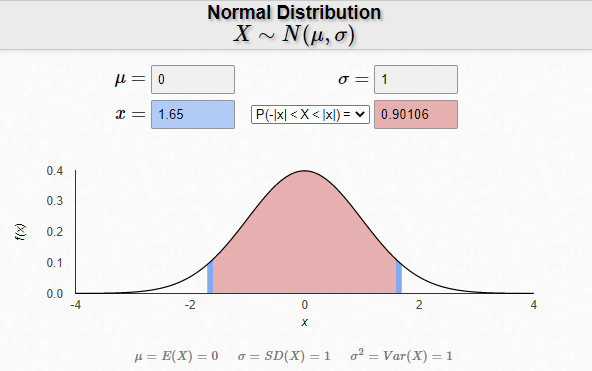

Não foi possível calcular: DatConcretagemRealizado_atraso para UTE: zero-size array to reduction operation minimum which has no identity
Não foi possível calcular: DatConcretagemRealizado_atraso para UFV: zero-size array to reduction operation minimum which has no identity


,DatInicioObraRealizado_atraso,DatConcretagemRealizado_atraso,DatMontagemRealizado_atraso,DatLiberacaoSFGTeste_atraso
UHE,86.5%,87.3%,76.8%,99.9%
UTE,80.8%,-,79.6%,99.3%
PCH,96.1%,96.9%,98.6%,99.8%
CGH,69.2%,87.1%,92.2%,99.7%
EOL,88.8%,88.4%,91.7%,99.9%
UFV,94.1%,-,94.5%,99.0%


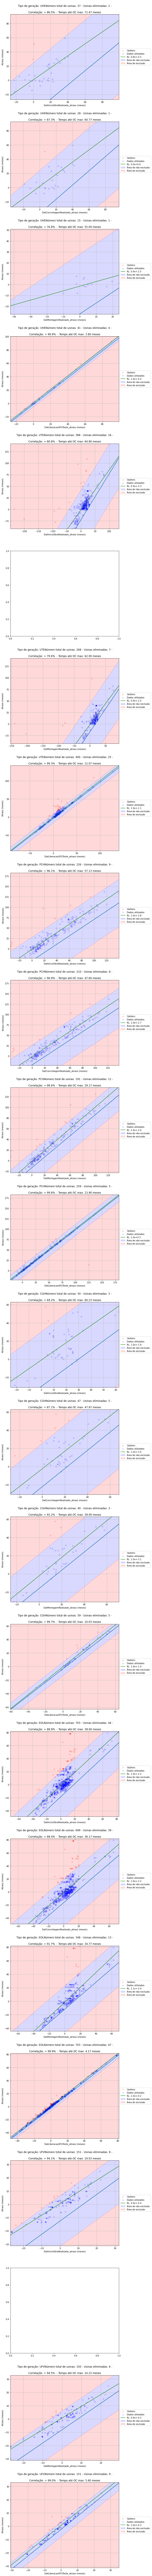

In [25]:
plot_created = False
analises_origem =["Ambos"]     #["skate","bdworgs","Ambos"]

matrix_pearson = {}
matrix_pearson_out = {}

def calc_regression(x,y):
    res = stats.linregress(x.flatten(), y.flatten())
    a, b, r, p_value, std_err = res    
    return [a, b, r, p_value, std_err]


def extract_xy(df : pd.DataFrame, x_name : str , y_name : str, order_by : str):
    idx_notna = (df[x_name].notna()) &  (df[y_name].notna())
    ordered_notna = df[idx_notna].sort_values(by = order_by)
    x = ordered_notna[x_name]
    y = ordered_notna[y_name]
    try:
        x = x.dt.days.to_numpy()
        y = y.dt.days.to_numpy()
    except:
        pass
    xy = np.zeros((2,x.shape[0]))
    xy[0] = x
    xy[1] = y
    return xy
    

def p(SigTipoGeracao,nome_coluna,ax):
    # Calcula outliers
    # Máscara com apenas indices que correspondem ao tipo geração especificado
    idx_geracao = atraso_usina.SigTipoGeracao == SigTipoGeracao 
    
    # Todos pares x,y para o tipo geracao tal que: x = Atraso y = Atraso do marco especificado
    x1,y1 =  extract_xy(atraso_usina[idx_geracao], nome_coluna, "Atraso", nome_coluna)/30
    x_plot = np.linspace(x1.min()-10,x1.max()+10,100)
    m = dict_tempo_construcao_mean_dp[SigTipoGeracao][dict_marco_nome[nome_coluna[:-7]]]["media"]
    dp = dict_tempo_construcao_mean_dp[SigTipoGeracao][dict_marco_nome[nome_coluna[:-7]]]["dp"]
    th_mes = (th*dp)+m
    m = m.days/30
    dp = dp.days/30
    outliers = ((tempo_construcao_por_usina[dict_marco_nome[nome_coluna[:-7]]]) > th_mes)| ((tempo_construcao_por_usina[dict_marco_nome[nome_coluna[:-7]]]) < -th_mes)
    x2,y2 = extract_xy(atraso_usina[idx_geracao & outliers], nome_coluna, "Atraso", nome_coluna)/30
    x3,y3 = extract_xy(atraso_usina[idx_geracao & ~outliers], nome_coluna, "Atraso", nome_coluna)/30
    a, b, r, p_value, std_err = calc_regression(x3,y3)
    p.r_str = f"{100*r:.1f}%"
    th_mes = th_mes.days/30
    
    # Plota resultados
    ax.scatter(x2,y2,color="red",alpha=0.15,label="Outliers")
    ax.scatter(x3,y3,color="blue",alpha=0.15,label="Dados utilizados")
    ax.plot(x_plot,a*x_plot+b+1,color="green",label= f"RL: {a:.1f}x+{b:.1f}")
    ax.set_title(f"""\nTipo de geração: {SigTipoGeracao}Número total de usinas: {x1.shape[0]} - Usinas eliminadas: {x2.shape[0]} -\n\nCorrelação: = {p.r_str}  - Tempo até OC max: {th_mes:.2f} meses""")
    ax.grid()
    ax.plot(x_plot,x_plot-m,linewidth=2)
    ax.fill_between(x_plot,x_plot-th_mes-m,x_plot+th_mes-m,color="blue",alpha=0.15,label="Área de não exclusão")
    ax.fill_between(x_plot,x_plot-th_mes-m,y1.min(),color="red",alpha=0.15,label="Área de exclusão")
    ax.fill_between(x_plot,x_plot+th_mes-m,y1.max(),color="red",alpha=0.15)
    ax.set_xlim(x1.min(),x1.max())
    ax.set_ylim(y1.min(),y1.max())
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel(f"{nome_coluna} (meses)")
    ax.set_ylabel(f"Atraso (meses)")

th = 1.65
for k,origem in enumerate(analises_origem):
    
    if not plot_created:    
        num_subplots = (len(tipos_geracao))*(len(nomes_colunas_atrasos))
        fig, axes = plt.subplots(num_subplots,len(analises_origem),figsize=(len(analises_origem)*10,num_subplots*7))
        plot_created =True
    count = -1
    for i,SigTipoGeracao in enumerate(tipos_geracao):
        matrix_pearson[SigTipoGeracao] = []
        for nome_coluna in nomes_colunas_atrasos:
            count+=1
            ax = axes[count]
            try:
                p(SigTipoGeracao,nome_coluna,ax)
                matrix_pearson[SigTipoGeracao].append(p.r_str)
            except (ValueError,AttributeError) as error:
                print(rf"Não foi possível calcular: {nome_coluna} para {SigTipoGeracao}: {error}")
                matrix_pearson[SigTipoGeracao].append("-")
                
matrix_pearson =  pd.DataFrame(matrix_pearson,nomes_colunas_atrasos)
display(matrix_pearson.T)
plt.tight_layout()
plt.savefig("calculos_atrasos.pdf")
person_matrix = pd.DataFrame(matrix_pearson,nomes_colunas_atrasos)